# Connecting to the 311 API
## Pulling data on illegal dumping from 2020 to present

Several of Philadelphia'a Open Data are hosted on Carto so we are calling in the carto and requests libraries.

In [2]:
import carto
import requests
from sklearn.cluster import KMeans
import geopandas as gpd
import pandas as pd
import rtree
import pygris as pg
import matplotlib.pyplot as plt


The 311 API contains data of 311 requests from December 8, 2014 to present and updates data daily. The requests are submitted via the 311 mobile application, calls, walk-ins, emails, the 311 website or social media. The following request pulls all illegal dumping complaints.

In [3]:
#connect to 311 API
url = '''https://phl.carto.com/api/v2/sql?q=SELECT *
        FROM public_cases_fc
        WHERE subject = 'Illegal Dumping'
        '''

response = requests.get(url)

data = response.json()

Look at how the data is structured

In [4]:
dict(list(data.items())[0:2])

{'rows': [{'cartodb_id': 27,
   'the_geom': '0101000020E6100000462E933CF2C852C0AAAFF8976E004440',
   'the_geom_webmercator': '0101000020110F0000BA3255A67AE85FC1840CA92F60905241',
   'objectid': 23171921,
   'service_request_id': 14841749,
   'subject': 'Illegal Dumping',
   'status': 'Closed',
   'status_notes': None,
   'service_name': 'Illegal Dumping',
   'service_code': 'SR-ST02',
   'agency_responsible': 'Streets Department',
   'service_notice': '5 Business Days',
   'requested_datetime': '2022-04-04T19:30:32Z',
   'updated_datetime': '2023-02-15T22:11:37Z',
   'expected_datetime': '2022-04-11T20:00:00Z',
   'closed_datetime': '2022-04-18T10:23:35Z',
   'address': '3416 N 6TH ST',
   'zipcode': '19140',
   'media_url': None,
   'lat': 40.003375047,
   'lon': -75.139784955},
  {'cartodb_id': 86,
   'the_geom': '0101000020E610000085615D6830CE52C016363D079AF74340',
   'the_geom_webmercator': '0101000020110F0000EC7E5B7662F15FC10AC7BD1397865241',
   'objectid': 23123101,
   'service_r

In [5]:
data["rows"][0]["lat"]

40.003375047

Make a list of coordinates to calculate kmeans clusters

In [6]:
coords=[]
for i in range(len(data["rows"])):
    if data["rows"][i]["lat"] or data["rows"][i]["lon"] is not None:
        lat = data["rows"][i]["lat"]
        lon = data["rows"][i]["lon"]
        c = [lat,lon]
        coords.append(c)
coords

[[40.003375047, -75.139784955],
 [39.934388065, -75.221704569],
 [39.986229817, -75.125070894],
 [40.011450262, -75.143679805],
 [40.032146302, -75.127765975],
 [40.087227633, -75.045202333],
 [39.937782794, -75.201033752],
 [39.9423411, -75.150651127],
 [40.004560937, -75.075414586],
 [40.041760093, -75.132217196],
 [40.041378086, -75.146059504],
 [39.998276307, -75.176658139],
 [39.964480277, -75.247445401],
 [39.989660727, -75.169642915],
 [40.047567, -75.115395961],
 [39.964577904, -75.23629978],
 [39.984186458, -75.114632787],
 [39.972828236, -75.239016616],
 [39.946988852, -75.168110251],
 [39.920058918, -75.156142596],
 [39.932126632, -75.160709046],
 [39.955682115, -75.239208338],
 [39.938750008, -75.16063808],
 [39.944309068, -75.168234604],
 [39.946988852, -75.168110251],
 [40.023224932, -75.040937688],
 [39.973763616, -75.230498434],
 [40.014027361, -75.147412735],
 [39.926746457, -75.155728936],
 [40.030439438, -75.03050675],
 [40.031015661, -75.029616196],
 [39.9997045, -7

###### Convert the data to a dataframe 

In [7]:
df = pd.DataFrame.from_dict(data['rows'])
df

,cartodb_id,the_geom,the_geom_webmercator,objectid,service_request_id,subject,status,status_notes,service_name,service_code,...,service_notice,requested_datetime,updated_datetime,expected_datetime,closed_datetime,address,zipcode,media_url,lat,lon
0,27,0101000020E6100000462E933CF2C852C0AAAFF8976E00...,0101000020110F0000BA3255A67AE85FC1840CA92F6090...,23171921,14841749,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,5 Business Days,2022-04-04T19:30:32Z,2023-02-15T22:11:37Z,2022-04-11T20:00:00Z,2022-04-18T10:23:35Z,3416 N 6TH ST,19140,None,40.003375,-75.139785
1,86,0101000020E610000085615D6830CE52C016363D079AF7...,0101000020110F0000EC7E5B7662F15FC10AC7BD139786...,23123101,14780011,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,5 Business Days,2022-03-07T14:13:11Z,2023-02-15T22:01:20Z,2022-03-14T20:00:00Z,2022-07-15T04:48:08Z,2000 S 56TH ST,19143,https://d17aqltn7cihbm.cloudfront.net/uploads/...,39.934388,-75.221705
2,87,0101000020E6100000D38E552901C852C0B79E5BC73CFE...,0101000020110F00003B40C928E1E65FC11DA7EA5BF18D...,22786271,14360829,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,5 Business Days,2021-08-20T08:40:51Z,2022-03-12T02:39:54Z,2021-08-26T20:00:00Z,2021-08-24T07:34:44Z,2011 E HUNTINGDON ST,19125,https://d17aqltn7cihbm.cloudfront.net/uploads/...,39.986230,-75.125071
3,98,0101000020E61000002286C20C32C952C0871DBE337701...,0101000020110F00001F9FFC0AE7E85FC1B051BC958591...,23123103,14780013,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,5 Business Days,2022-03-07T14:13:26Z,2023-02-15T22:00:29Z,2022-03-14T20:00:00Z,2022-03-28T06:07:47Z,3890 N 10TH ST,19140,https://d17aqltn7cihbm.cloudfront.net/uploads/...,40.011450,-75.143680
4,174,0101000020E610000045AC51512DC852C0FD97B55E1D04...,0101000020110F0000CDEABD292CE75FC102F1B6B27594...,22844416,14431511,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,5 Business Days,2021-09-21T05:01:24Z,2023-02-15T22:08:42Z,2021-09-27T20:00:00Z,2021-09-30T10:49:07Z,5325 N 3RD ST,19120,None,40.032146,-75.127766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187729,4843920,0101000020E6100000592BC17F06CA52C0F8A502177900...,0101000020110F0000D92BC5E84FEA5FC18D73E3D26B90...,23921628,15782004,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,5 Business Days,2023-03-23T15:44:59Z,2023-04-12T08:52:09Z,2023-03-30T20:00:00Z,2023-04-12T12:42:08Z,1626 W WESTMORELAND ST,19140,None,40.003695,-75.156647
187730,4843977,0101000020E6100000D9969E3CAECB52C0590D91ECF4FC...,0101000020110F0000C421A4AB1FED5FC19559DCF8858C...,23960358,15834302,Illegal Dumping,Open,None,Illegal Dumping,SR-ST02,...,5 Business Days,2023-04-18T13:34:41Z,2023-04-20T10:23:54Z,2023-04-25T20:00:00Z,None,N DOVER ST & W THOMPSON ST,None,None,39.976224,-75.182510
187731,4844129,0101000020E61000006E7AE5B4C6CE52C02B4A6CEB65FC...,0101000020110F000079439EC261F25FC1F2015A7CE78B...,23910721,15814216,Illegal Dumping,Open,None,Illegal Dumping,SR-ST02,...,5 Business Days,2023-04-10T12:15:19Z,2023-04-10T13:53:10Z,2023-04-17T20:00:00Z,None,1242 N 55TH ST,19131,None,39.971860,-75.230878
187732,121939,0101000020E61000007288B83955CE52C0FE6001C86003...,0101000020110F00005EEC4500A1F15FC1E313FC85A493...,19868042,10918488,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,5 Business Days,2016-09-01T16:06:04Z,2022-03-12T06:28:58Z,2016-09-08T20:00:00Z,2016-09-16T07:30:28Z,4363 CRESSON ST,19127,None,40.026391,-75.223952


###### Convert the dataframe to a geodataframe

In [8]:
#the 311 API data's crs is in EPSG:4326
gdf = gpd.GeoDataFrame(df, geometry= gpd.points_from_xy(df['lon'], df['lat']),crs="EPSG:4326")
gdf.head()

C:\Users\tup48123\Anaconda3\envs\geospatialProject\lib\site-packages\geopandas\array.py:275: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  return GeometryArray(vectorized.points_from_xy(x, y, z), crs=crs)


,cartodb_id,the_geom,the_geom_webmercator,objectid,service_request_id,subject,status,status_notes,service_name,service_code,...,requested_datetime,updated_datetime,expected_datetime,closed_datetime,address,zipcode,media_url,lat,lon,geometry
0,27,0101000020E6100000462E933CF2C852C0AAAFF8976E00...,0101000020110F0000BA3255A67AE85FC1840CA92F6090...,23171921,14841749,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2022-04-04T19:30:32Z,2023-02-15T22:11:37Z,2022-04-11T20:00:00Z,2022-04-18T10:23:35Z,3416 N 6TH ST,19140,None,40.003375,-75.139785,POINT (-75.13978 40.00338)
1,86,0101000020E610000085615D6830CE52C016363D079AF7...,0101000020110F0000EC7E5B7662F15FC10AC7BD139786...,23123101,14780011,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2022-03-07T14:13:11Z,2023-02-15T22:01:20Z,2022-03-14T20:00:00Z,2022-07-15T04:48:08Z,2000 S 56TH ST,19143,https://d17aqltn7cihbm.cloudfront.net/uploads/...,39.934388,-75.221705,POINT (-75.22170 39.93439)
2,87,0101000020E6100000D38E552901C852C0B79E5BC73CFE...,0101000020110F00003B40C928E1E65FC11DA7EA5BF18D...,22786271,14360829,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2021-08-20T08:40:51Z,2022-03-12T02:39:54Z,2021-08-26T20:00:00Z,2021-08-24T07:34:44Z,2011 E HUNTINGDON ST,19125,https://d17aqltn7cihbm.cloudfront.net/uploads/...,39.986230,-75.125071,POINT (-75.12507 39.98623)
3,98,0101000020E61000002286C20C32C952C0871DBE337701...,0101000020110F00001F9FFC0AE7E85FC1B051BC958591...,23123103,14780013,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2022-03-07T14:13:26Z,2023-02-15T22:00:29Z,2022-03-14T20:00:00Z,2022-03-28T06:07:47Z,3890 N 10TH ST,19140,https://d17aqltn7cihbm.cloudfront.net/uploads/...,40.011450,-75.143680,POINT (-75.14368 40.01145)
4,174,0101000020E610000045AC51512DC852C0FD97B55E1D04...,0101000020110F0000CDEABD292CE75FC102F1B6B27594...,22844416,14431511,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2021-09-21T05:01:24Z,2023-02-15T22:08:42Z,2021-09-27T20:00:00Z,2021-09-30T10:49:07Z,5325 N 3RD ST,19120,None,40.032146,-75.127766,POINT (-75.12777 40.03215)


###### Let's plot the data as a heatmap to get an understanding of its geographic distribution
Point Breeze/Grey's Ferry and Kensington seem to be hotspots

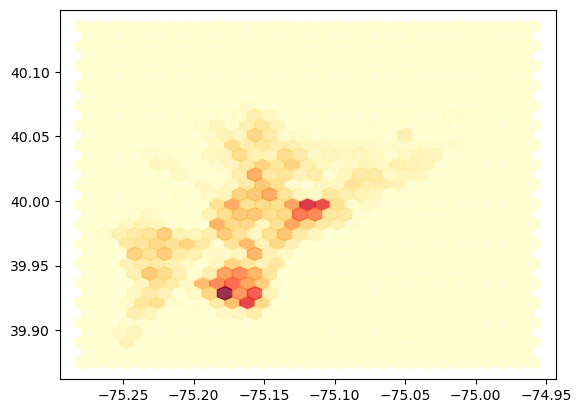

In [9]:
plt.hexbin(gdf['lon'], gdf['lat'], gridsize=30, cmap='YlOrRd', alpha=0.8)

###### Let's see if a kmeans analysis tells us something about the data

In [10]:
#calculate kmeans clusters
kmeans = KMeans(n_clusters=5, random_state=0).fit(coords)

kmeans.labels_
#len(coords)

array([1, 3, 1, ..., 3, 4, 1])

Add the kmeans clusters to the datafram

In [11]:
for i in range(len(kmeans.labels_)):
    gdf.loc[i,'kmeans_label'] = kmeans.labels_[i]

gdf.head()

,cartodb_id,the_geom,the_geom_webmercator,objectid,service_request_id,subject,status,status_notes,service_name,service_code,...,updated_datetime,expected_datetime,closed_datetime,address,zipcode,media_url,lat,lon,geometry,kmeans_label
0,27,0101000020E6100000462E933CF2C852C0AAAFF8976E00...,0101000020110F0000BA3255A67AE85FC1840CA92F6090...,23171921,14841749,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2023-02-15T22:11:37Z,2022-04-11T20:00:00Z,2022-04-18T10:23:35Z,3416 N 6TH ST,19140,None,40.003375,-75.139785,POINT (-75.13978 40.00338),1.0
1,86,0101000020E610000085615D6830CE52C016363D079AF7...,0101000020110F0000EC7E5B7662F15FC10AC7BD139786...,23123101,14780011,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2023-02-15T22:01:20Z,2022-03-14T20:00:00Z,2022-07-15T04:48:08Z,2000 S 56TH ST,19143,https://d17aqltn7cihbm.cloudfront.net/uploads/...,39.934388,-75.221705,POINT (-75.22170 39.93439),3.0
2,87,0101000020E6100000D38E552901C852C0B79E5BC73CFE...,0101000020110F00003B40C928E1E65FC11DA7EA5BF18D...,22786271,14360829,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2022-03-12T02:39:54Z,2021-08-26T20:00:00Z,2021-08-24T07:34:44Z,2011 E HUNTINGDON ST,19125,https://d17aqltn7cihbm.cloudfront.net/uploads/...,39.986230,-75.125071,POINT (-75.12507 39.98623),1.0
3,98,0101000020E61000002286C20C32C952C0871DBE337701...,0101000020110F00001F9FFC0AE7E85FC1B051BC958591...,23123103,14780013,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2023-02-15T22:00:29Z,2022-03-14T20:00:00Z,2022-03-28T06:07:47Z,3890 N 10TH ST,19140,https://d17aqltn7cihbm.cloudfront.net/uploads/...,40.011450,-75.143680,POINT (-75.14368 40.01145),4.0
4,174,0101000020E610000045AC51512DC852C0FD97B55E1D04...,0101000020110F0000CDEABD292CE75FC102F1B6B27594...,22844416,14431511,Illegal Dumping,Closed,None,Illegal Dumping,SR-ST02,...,2023-02-15T22:08:42Z,2021-09-27T20:00:00Z,2021-09-30T10:49:07Z,5325 N 3RD ST,19120,None,40.032146,-75.127766,POINT (-75.12777 40.03215),4.0


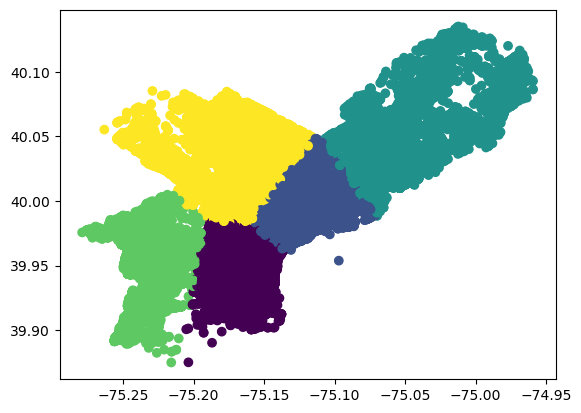

In [12]:
#plot kmeans clusters
#this is not very helpful

plt.scatter([x[1] for x in coords], [x[0] for x in coords], c=kmeans.labels_)
#kmeans.labels_

The kmean clusters do not give us a lot of insight on the data so we will move on from this.

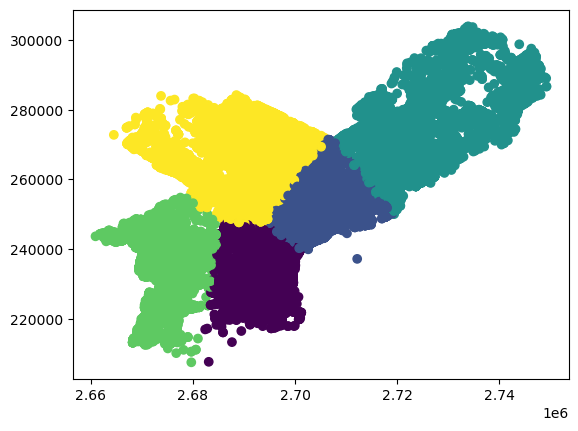

In [16]:
import pyproj

transformer = pyproj.Transformer.from_crs('EPSG:4326', 'EPSG:2272')

new_coords = [transformer.transform(coord[0], coord[1]) for coord in coords]

#plot
plt.scatter([x[0] for x in new_coords], [x[1] for x in new_coords], c=kmeans.labels_)

###### Add census tracts as a geodataframe

In [17]:
tracts = pg.tracts("PA", "Philadelphia", cb = False, cache = True)
tracts.head()

Using the default year of 2021
Using FIPS code '42' for input 'PA'
Using FIPS code '101' for input 'Philadelphia'


,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
68,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,+39.9332720,-075.2132103,"POLYGON ((-75.22235 39.93105, -75.22129 39.931..."
69,42,101,980902,42101980902,9809.02,Census Tract 9809.02,G5020,S,132548,50536,+39.9346276,-075.2046321,"POLYGON ((-75.20684 39.93409, -75.20655 39.934..."
70,42,101,980904,42101980904,9809.04,Census Tract 9809.04,G5020,S,1570844,158459,+39.9247300,-075.2036710,"POLYGON ((-75.21243 39.92523, -75.21130 39.928..."
71,42,101,980903,42101980903,9809.03,Census Tract 9809.03,G5020,S,171154,0,+39.9347932,-075.2009884,"POLYGON ((-75.20422 39.93285, -75.20305 39.934..."
72,42,101,980906,42101980906,9809.06,Census Tract 9809.06,G5020,S,2945390,383112,+39.9095823,-075.1984052,"POLYGON ((-75.21612 39.90964, -75.21454 39.910..."


###### Check if the CRS match for tracts gdf and 311 points data in order to perform a spatial join

In [404]:
#check CRS
tracts.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - NAD83
- bounds: (167.65, 14.92, -47.74, 86.46)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [410]:
gdf=gdf.to_crs(2272)
gdf.crs

<Projected CRS: EPSG:2272>
Name: NAD83 / Pennsylvania South (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: USA - Pennsylvania - SPCS - S
- bounds: (-80.53, 39.71, -74.72, 41.18)
Coordinate Operation:
- name: SPCS83 Pennsylvania South zone (US Survey feet)
- method: Lambert Conic Conformal (2SP)
Datum: North American Datum 1983
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

<AxesSubplot: >

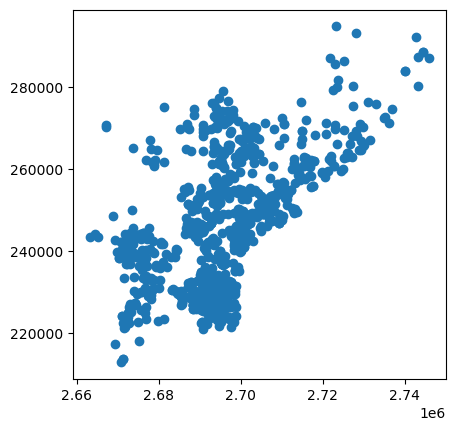

In [411]:
gdf.head(1000).plot()

<AxesSubplot: >

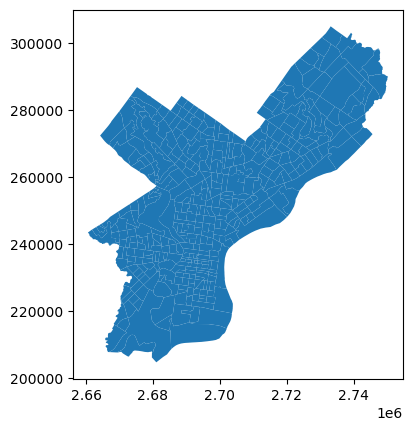

In [412]:
#change crs
tracts = tracts.to_crs(2272)
tracts.plot()

###### Points layer overlaps with polygon layer

<AxesSubplot: >

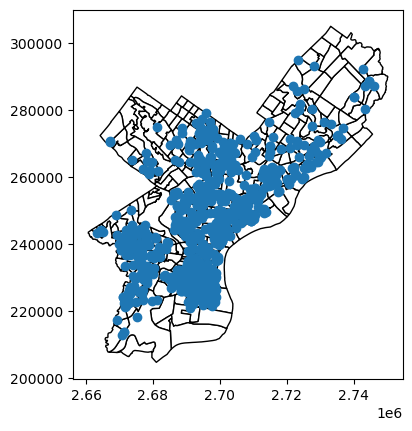

In [413]:
#plot
ax = tracts.plot(color='white', edgecolor='black')

gdf.head(1000).plot(ax=ax)

In [414]:
#check columns in tracts layer
tracts.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

### Aggregate points and polygon layers

In [415]:
#aggregate

agg = gpd.sjoin(gdf, tracts, how="inner", op='within')
agg.columns

Index(['cartodb_id', 'the_geom', 'the_geom_webmercator', 'objectid',
       'service_request_id', 'subject', 'status', 'status_notes',
       'service_name', 'service_code', 'agency_responsible', 'service_notice',
       'requested_datetime', 'updated_datetime', 'expected_datetime',
       'closed_datetime', 'address', 'zipcode', 'media_url', 'lat', 'lon',
       'geometry', 'kmeans_label', 'index_right', 'STATEFP', 'COUNTYFP',
       'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON'],
      dtype='object')

###### Group the aggregated data by GEOID in teh tracts layer

In [416]:
#group  by GEOID

agg2 = agg.groupby("GEOID")['objectid'].count()
agg2.rename('count')
agg2

GEOID
42101000101    639
42101000102    400
42101000200    830
42101000300    388
42101000401    161
              ... 
42101980905      3
42101980906     47
42101989100      8
42101989200      3
42101989300    202
Name: objectid, Length: 407, dtype: int64

###### Merge the aggregated points by GEOID

In [417]:
#merge tracts with agg
#get the count of points by GEOID

tracts = tracts.merge(agg2, on="GEOID")
tracts = tracts.rename(columns ={'objectid':'count'})
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,count
0,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,+39.9332720,-075.2132103,"POLYGON ((2677269.006 227883.043, 2677559.538 ...",458
1,42,101,980902,42101980902,9809.02,Census Tract 9809.02,G5020,S,132548,50536,+39.9346276,-075.2046321,"POLYGON ((2681586.156 229114.531, 2681662.861 ...",21
2,42,101,980904,42101980904,9809.04,Census Tract 9809.04,G5020,S,1570844,158459,+39.9247300,-075.2036710,"POLYGON ((2680111.595 225844.686, 2680393.281 ...",46
3,42,101,980903,42101980903,9809.03,Census Tract 9809.03,G5020,S,171154,0,+39.9347932,-075.2009884,"POLYGON ((2682331.858 228686.312, 2682639.371 ...",51
4,42,101,980906,42101980906,9809.06,Census Tract 9809.06,G5020,S,2945390,383112,+39.9095823,-075.1984052,"POLYGON ((2679238.648 220137.025, 2679671.841 ...",47


In [418]:
tracts.columns

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'count'],
      dtype='object')

###### Plot the tracts by count of illegal dumping complaints in the 311 data

<AxesSubplot: >

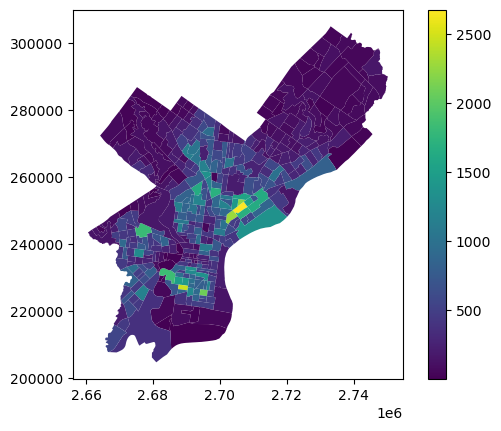

In [419]:
#plot with agg

tracts.plot(column='count', legend = True)


###### Group the aggregated data by GEOID and request status
Check if the location of open and closed requests says something interesting

In [420]:
#agg by status completed
agg_status = agg.groupby(["GEOID", 'status'])['status'].count()
agg_status

GEOID        status
42101000101  Closed    637
             Open        2
42101000102  Closed    400
42101000200  Closed    828
             Open        2
                      ... 
42101980906  Open        2
42101989100  Closed      8
42101989200  Closed      3
42101989300  Closed    201
             Open        1
Name: status, Length: 706, dtype: int64

In [426]:
tracts = tracts.merge(agg_status, on="GEOID")
tracts = tracts.rename(columns ={'status_x':'status_closed', 'status_y': 'status_open'})
tracts.columns
#print(tracts['status_x'].sum()) #356621
#print(tracts['status_y'].sum()) #186604

Index(['STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC',
       'FUNCSTAT', 'ALAND', 'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry',
       'count', 'status_closed', 'status_open'],
      dtype='object')

In [427]:
tracts.head()

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,count,status_closed,status_open
0,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,+39.9332720,-075.2132103,"POLYGON ((2677269.006 227883.043, 2677559.538 ...",458,446,446
1,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,+39.9332720,-075.2132103,"POLYGON ((2677269.006 227883.043, 2677559.538 ...",458,446,12
2,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,+39.9332720,-075.2132103,"POLYGON ((2677269.006 227883.043, 2677559.538 ...",458,12,446
3,42,101,039100,42101039100,391,Census Tract 391,G5020,S,1119799,133239,+39.9332720,-075.2132103,"POLYGON ((2677269.006 227883.043, 2677559.538 ...",458,12,12
4,42,101,980902,42101980902,9809.02,Census Tract 9809.02,G5020,S,132548,50536,+39.9346276,-075.2046321,"POLYGON ((2681586.156 229114.531, 2681662.861 ...",21,21,21


The plots do not seem to say anything new about the data

<AxesSubplot: >

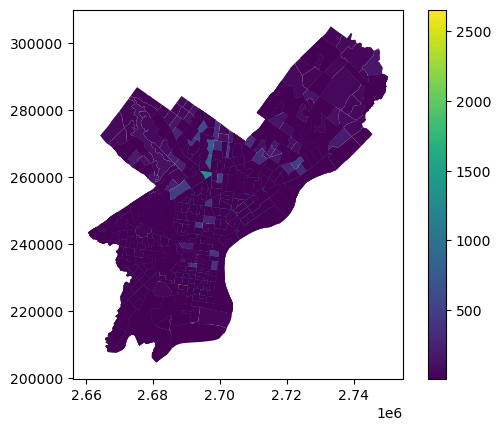

In [432]:
#plot with status agg
#tells us nothing new
tracts.plot(column='status_open', legend = True)

In [441]:
agg.columns

Index(['cartodb_id', 'the_geom', 'the_geom_webmercator', 'objectid',
       'service_request_id', 'subject', 'status', 'status_notes',
       'service_name', 'service_code', 'agency_responsible', 'service_notice',
       'requested_datetime', 'updated_datetime', 'expected_datetime',
       'closed_datetime', 'address', 'zipcode', 'media_url', 'lat', 'lon',
       'geometry', 'kmeans_label', 'index_right', 'STATEFP', 'COUNTYFP',
       'TRACTCE', 'GEOID', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON'],
      dtype='object')

In [ ]:
#save tracts gdf to output folder
tracts.to_file("output/tracts.gpkg", driver="GPKG")